In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from dbscan_cluster import run_dbscan
from cluster_utils import cluster_plot, cluster_plot_galactic
import json

from astropy.coordinates import SkyCoord, ICRS
import astropy.units as u
from simbad_download import resolve_name
from uncertainties import unumpy, ufloat
from sklearn.preprocessing import StandardScaler

In [8]:
CLUSTER_NAME: str = 'NGC 7789'

In [9]:
gaiadr3 = pd.read_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}.csv')
normalized = np.loadtxt(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_normalized.dat')
uncert = np.loadtxt(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_normalized_uncert.dat')
normalized_cp = np.loadtxt(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_normalized_cp.dat')
uncert_cp = np.loadtxt(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_normalized_cp_uncert.dat')
lit = pd.read_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_literature.csv')

In [10]:
lit_dr3 = pd.merge(left=lit[['EDR3 id', 'reported', 'TIC']], right=gaiadr3, left_on='EDR3 id', right_on='source_id', how='inner')

In [11]:
cp_ra, cp_dec, cp_par, cp_pmra, cp_pmdec, cp_radvel = resolve_name(CLUSTER_NAME)

In [12]:
cp_par

0.453

In [13]:
galactic_coords = SkyCoord(ra=cp_ra*u.deg, dec=cp_dec*u.deg,
                           pm_ra_cosdec=cp_pmra*u.mas/u.year, frame=ICRS,
                           pm_dec=cp_pmdec*u.mas/u.year).galactic

In [14]:
galactic_coords

<SkyCoord (Galactic): (l, b) in deg
    (115.52703297, -5.36590357)
 (pm_l_cosb, pm_b) in mas / yr
    (-1.30574728, -1.69752674)>

# Plain DBSCAN

In [25]:
clustered, noise, found, not_found = run_dbscan(normalized, gaiadr3, lit_dr3, 0.4, 50, False)

Classified into 2 labels.
Clustered: 478/601
478/601 sources from literature clustered
3256 clustered sources.


In [36]:
clustered_sets = []
noise_sets = []
found_sets = []
not_found_sets = []

for _ in range(50):
    normalized_u = normalized + np.random.normal(scale=np.abs(uncert), size=normalized.shape)
    clustered, noise, found, not_found = run_dbscan(normalized_u, gaiadr3, lit_dr3, 0.5, 50, False)
    clustered_sets.append(clustered)
    noise_sets.append(noise)
    found_sets.append(found)
    not_found_sets.append(not_found)

Classified into 2 labels.
Clustered: 501/601
501/601 sources from literature clustered
3548 clustered sources.
Classified into 2 labels.
Clustered: 506/601
506/601 sources from literature clustered
3573 clustered sources.
Classified into 2 labels.
Clustered: 509/601
509/601 sources from literature clustered
3582 clustered sources.
Classified into 2 labels.
Clustered: 501/601
501/601 sources from literature clustered
3564 clustered sources.
Classified into 2 labels.
Clustered: 500/601
500/601 sources from literature clustered
3510 clustered sources.
Classified into 2 labels.
Clustered: 503/601
503/601 sources from literature clustered
3525 clustered sources.
Classified into 2 labels.
Clustered: 506/601
506/601 sources from literature clustered
3567 clustered sources.
Classified into 2 labels.
Clustered: 511/601
511/601 sources from literature clustered
3553 clustered sources.
Classified into 2 labels.
Clustered: 511/601
511/601 sources from literature clustered
3576 clustered sources.
C

In [38]:
clustered = pd.concat(clustered_sets).drop_duplicates(subset=['source_id'])
len(clustered)

7425

In [39]:
found = pd.concat(found_sets).drop_duplicates(subset=['source_id'])
len(found)

567

In [40]:
not_found = pd.concat(not_found_sets).drop_duplicates(subset=['source_id'])
len(not_found)

256

In [41]:
clustered.head()

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,A_y,A_J,A_H,A_K,BP-RP,BP-RP_error,G_abs,G_abs_error,excess,label
14,1636148068921376768,Gaia DR3 1995033719416486144,1995033719416486144,535665643,2016.0,-1.30896,0.030904,56.539309,0.034162,0.488654,...,0.822213,0.516048,0.305319,0.196993,0.785278,0.004801,4.453738,0.201415,0.022953,0
19,1636148068921376768,Gaia DR3 1995033753776234368,1995033753776234368,740416905,2016.0,-1.284928,0.00987,56.532017,0.010525,0.472842,...,0.822213,0.516048,0.305319,0.196993,0.635016,0.000792,1.647434,0.066863,0.023416,0
26,1636148068921376768,Gaia DR3 1995033788135967744,1995033788135967744,1444149966,2016.0,-1.263851,0.018921,56.544206,0.019461,0.428173,...,0.772694,0.484968,0.286931,0.185128,0.643605,0.002073,3.068949,0.140696,0.020426,0
145,1636148068921376768,Gaia DR3 1995034612771440128,1995034612771440128,1516081854,2016.0,-1.382357,0.020267,56.571899,0.02409,0.448757,...,0.861366,0.540621,0.319858,0.206373,0.627395,0.002707,3.219463,0.146505,0.02876,0
174,1636148068921376768,Gaia DR3 1995034784568338048,1995034784568338048,1519673513,2016.0,-1.342378,0.023118,56.571951,0.026008,0.489519,...,0.822213,0.516048,0.305319,0.196993,0.736325,0.004024,3.87152,0.148969,0.027045,0


In [ ]:
occurences = clustered['source_id'].apply(lambda x:
                                          sum([len(np.intersect1d(cs.source_id.values, [x])) for cs in clustered_sets]))

In [ ]:
found['occurences'] = found['source_id'].apply(lambda x:
                                          sum([len(np.intersect1d(cs.source_id.values, [x])) for cs in found_sets]))/50.0

In [ ]:
not_found['occurences'] = 1.0-not_found['source_id'].apply(lambda x:
                                                       sum([len(np.intersect1d(cs.source_id.values, [x])) for cs in not_found_sets]))/50.0

In [ ]:
clustered['occurences'] = occurences/50.0
clustered.head()

In [ ]:
cp_coords = SkyCoord(ra=cp_ra*u.deg, dec=cp_dec*u.deg, frame=ICRS)
cp_ra = cp_coords.ra.wrap_at(180*u.deg).value

In [ ]:
plt.figure(figsize=(20, 10))
plt.scatter(clustered.ra, clustered.dec, 
            color='royalblue', alpha=clustered.occurences, label='Clustered', zorder=2, s=30.)
plt.scatter(noise.ra, noise.dec, color='skyblue', label='Unclustered', zorder=1, s=5., alpha=.3)
plt.scatter(lit_dr3.ra, lit_dr3.dec, color='black', zorder=1,
            marker='D', label='Reported in papers')

plt.gca().set_xlabel('$\\alpha$ [deg]', fontsize=20);
plt.gca().set_ylabel('$\delta$ [deg]', fontsize=20);


plt.arrow(cp_ra,
          cp_dec,
          cp_pmra*(u.arcsec/u.year).to(u.deg/u.year),
          cp_pmdec*(u.arcsec/u.year).to(u.deg/u.year),
          linewidth=3.,
          color='tomato',
          head_width=0.05,
          head_length=0.1,
          zorder=4, label='Cluster center proper motion')

lgnd = plt.legend(fontsize=14, loc='upper right');
for handle in lgnd.legendHandles:
    handle._sizes = [40];
    handle._alpha = 1.;

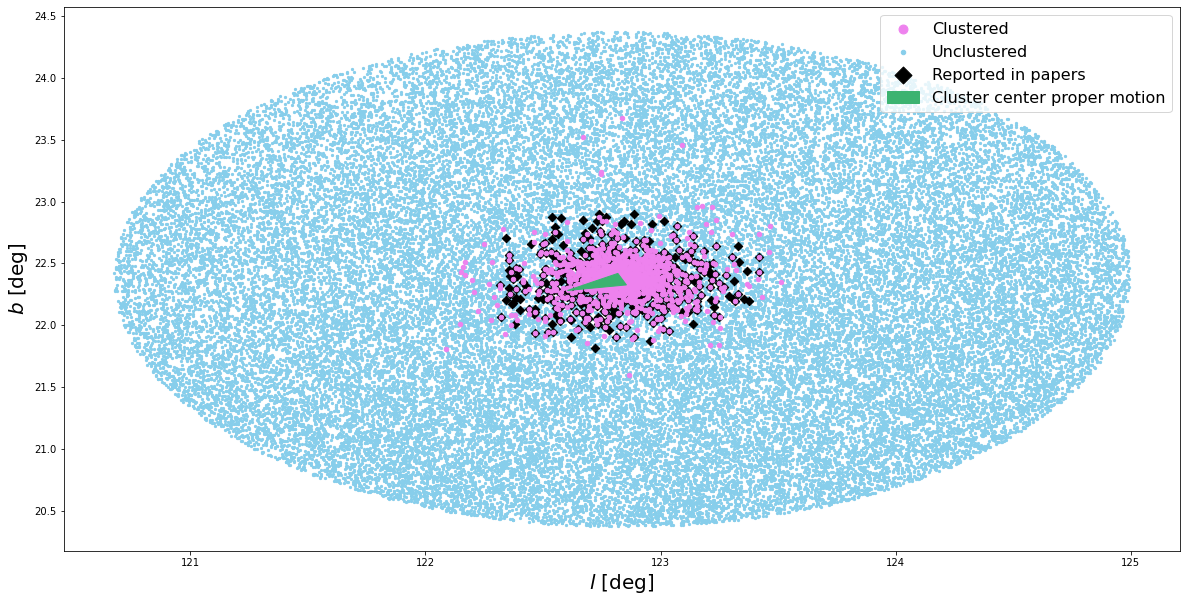

In [12]:
cluster_plot_galactic(clustered, gaiadr3, lit_dr3)
plt.arrow(galactic_coords.l.value,
          galactic_coords.b.value,
          galactic_coords.pm_l_cosb.to(u.deg/u.yr).value,
          galactic_coords.pm_b.to(u.deg/u.yr).value,
          linewidth=1.,
          color='mediumseagreen',
          head_width=0.1,
          head_length=0.25,
          zorder=4,
          label='Cluster center proper motion')
plt.legend(fontsize=16, loc='upper right', markerscale=2.);

In [28]:
clustered.to_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_clustered.csv')
found.to_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_found.csv')
not_found.to_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_not_found.csv')

# Convergent velocities

In [13]:
with open(f'optuna_db/{CLUSTER_NAME}/{CLUSTER_NAME.replace(" ", "_")}_cp_best_params.json', 'r') as f:
    best_params = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'optuna_db/NGC 188/NGC_188_cp_best_params.json'

In [ ]:
best_params

In [28]:
clustered, noise, found, not_found = run_dbscan(normalized_cp, gaiadr3, lit_dr3, 0.025, 25, False)

Classified into 51 labels.
Clustered: 724/957
724/957 sources from literature clustered
1384 clustered sources.


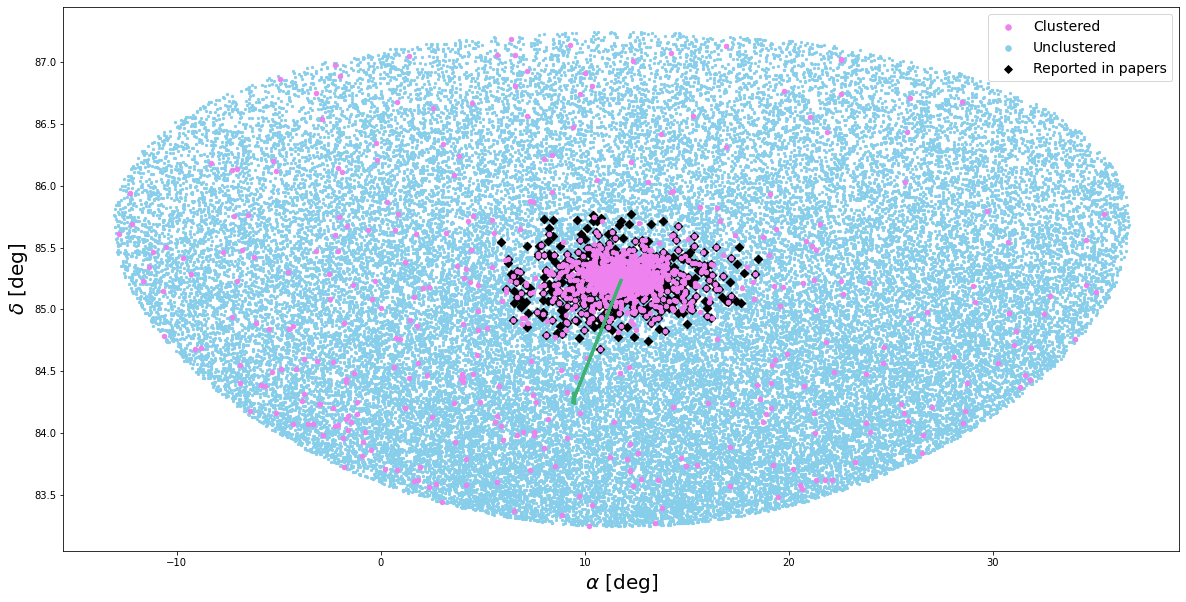

In [29]:
cluster_plot(clustered, gaiadr3, lit_dr3)
plt.arrow(cp_ra,
          cp_dec,
          cp_pmra,
          cp_pmdec,
          linewidth=3.,
          color='mediumseagreen',
          head_width=0.1,
          head_length=0.1,
          zorder=4)

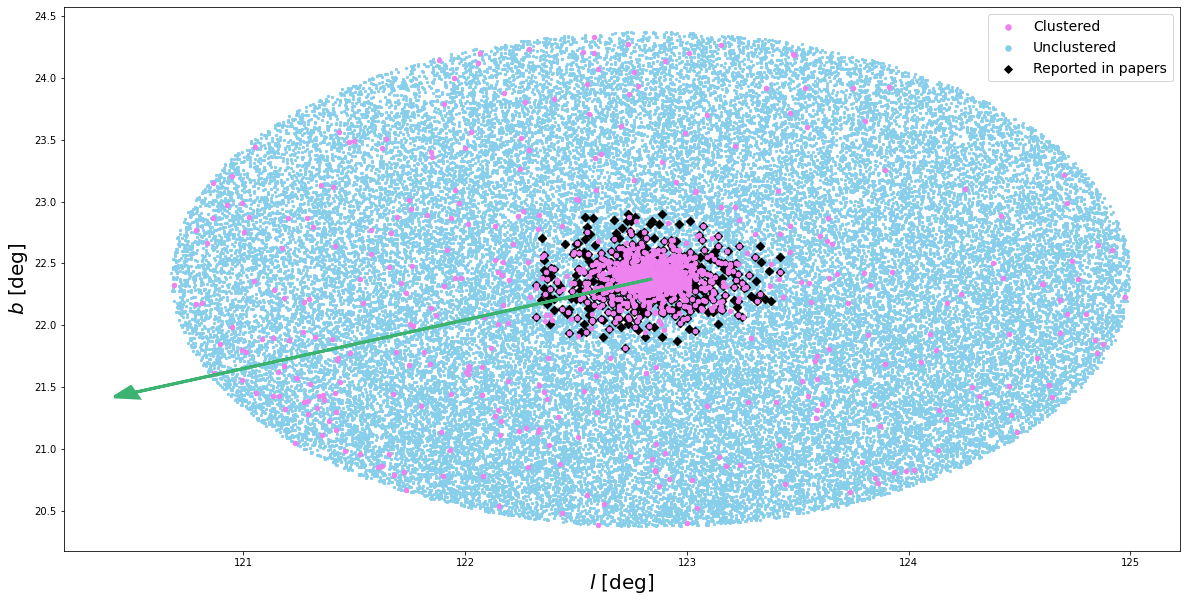

In [30]:
cluster_plot_galactic(clustered, gaiadr3, lit_dr3)
plt.arrow(galactic_coords.l.value,
          galactic_coords.b.value,
          galactic_coords.pm_l_cosb.value,
          galactic_coords.pm_b.value,
          linewidth=3.,
          color='mediumseagreen',
          head_width=0.1,
          head_length=0.1,
          zorder=4)

In [ ]:
a = np.loadtxt('Trumpler 5_isochrone.dat', usecols=(28, 29, 30))

In [ ]:
plt.plot(a[:-1, 1]-a[:-1, 2], a[:-1, 0])
plt.gca().invert_yaxis();